# imgtofmri

###### (DNNs as feature extractors for neural prediction):


In recent years, artificial deep neural networks (DNNs) have shown promise in predicting cortical responses in the human visual cortex when trained on real world categorization tasks [[Cichy et al. 2016](https://doi.org/10.1038/srep27755)]. These neural networks learn to extract features (e.g. shapes, textures, eyes) from naturalistic visual data that allow them to accurately classify objects, animals, and scenes in the images they process [[Olah et al. 2017](https://distill.pub/2017/feature-visualization/)]. In the context of neuroscience, these networks can be used to extract predominant features from input which can then be used to predict brain responses along a cortical processing hierarchy [[Eickenberg et al. 2017](https://doi.org/10.1016/j.neuroimage.2016.10.001)]. Research has also shown that the hierarchy of layers in a DNN can predict along a hierarchy of processing in the brain, where deeper, or higher, layers in a DNN best predict higher levels of cortical processing [[Kell et al. 2018](https://doi.org/10.1016/j.neuron.2018.03.044)]. Using DNNs for feature extraction and brain prediction has also been shown with other modalities, such as audio and language data [cite Huth] as well as  cross-modal audiovisual data [[Khosla et al. 2021](https://doi.org/10.1126/sciadv.abe7547)].

###### (Event boundary background):
Another burgeoning area of neuroscience investigates how humans segment a constant stream of perceptual input into discrete events of varying timescales [[Zacks, Tversky 2001](http://dx.doi.org/10.1037//0033-2909.127.1.3)]. Research in this area has shown that these discrete events can be identified from cortical activity patterns [[Baldassano et al. 2017](https://doi.org/10.1016/j.neuron.2017.06.041)] and the timescales of these events varies along a cortical hierarchy, with higher-order brain regions such as the posterior medial cortex showing larger timescales for events than early or late-visual regions. Movies are commonly used for studying this type of naturalistic perception with an fMRI scanner, and as such, previous research has also focused on decoding semantic content from natural movies [Huth et al. 2016](https://doi.org/10.3389/fnsys.2016.00081). However, many questions remain about the timescale of events in various brain regions, and about the extent to which these timescales can be predicted.

(should have more on modeling/prediction of events here) -- [[Reynolds 2010](https://doi.org/10.1080/15326900701399913)], [[Shin, Dubrow 2020](https://doi.org/10.1111/tops.12505)]

(related tools? Brain-Score?)


###### (model introduction):
In this notebook, we present imgtofmri, a python package and model that allows for quick predictions of group-averaged cortical responses to visual stimuli. As we outline in this notebook, we can use this model to predict brain responses to unseen images, or to more continuous, naturalistic stimuli such as movies. With an unseen dataset, twinset[cite], we show how our model can predict brain responses to various categories of visual stimulus, both within and across subjects. With movies, we focus on Pixar's Partly Cloudy[cite + also oliva's] and compare our model's frame-by-frame predictions to that of human subjects watching the same movie, showing that much of the event segmentation observed in the human brain can be explained by mid-level semantic information in the visual stimulus.


We build on this research, as well as on the open source BOLD5000 dataset and pretrained ResNet model as our CNN, to create a package for predicting group-averaged fMRI activity from images or movies.

<center>
<img src="img/overview.png" alt="drawing" width="500" align="center"/>
</center>

In this notebook, we overview use of the python and command line package, imgtofmri, as well as demonstrate the model's extension and prediction power to novel datasets not used in the training of the model.

## Using imgtofmri on an unseen dataset
We first show how we can use imgtofmri to predict fMRI responses to out-of-dataset images. We perform this on the [Twinset Dataset](http://twinsetfusion.csail.mit.edu/) compiled by Mohsenzadeh et al. This dataset is comprised of fMRI data for 33 adults viewing 156 images. These images are split across 5 categories:

<center>
<img src="img/twinset_cropped.png" alt="drawing" width="300" align="center"/>
</center>

We proceed by:
<ol>
<li>Downloading this dataset</li>
<li>Pushing it through our model with the imgtofmri.predict() function</li>
<li>Analyzing performance:</li>
    <ol>
<li>With the whole group</li>
<li>Within categories</li>
<li>Within subjects</li>
    </ol>
</ol>

In [74]:
%load_ext autoreload
%autoreload 2
import imgtofmri

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
input_dir = 'input_images/156ImageStimuliSet/'
output_dir = 'output_testing_aperture/'

# Options for ROIs are: EarlyVis, OPA, LOC, PPA, RSC
# We use LOC, PPA, and RSC for our tutorial, as they performed strongest above chance
rois = ['LOC', 'PPA', 'RSC']

In [76]:
url = 'http://wednesday.csail.mit.edu/fusion_rep/stimulus/156ImageStimuliSet.zip'
imgtofmri.load_imgs(url)

Downloaded and extracted: 156ImageStimuliSet.zip


In [3]:
imgtofmri.predict(input_dir, output_dir, rois)

Averaging MNI brains: 100%|██████████| 157/157 [00:13<00:00, 11.83it/s]


### Twinset Analyses

In [4]:
imgtofmri.twinset_generate_group_correlations(output_dir)

100%|██████████| 156/156 [07:19<00:00,  2.82s/it]


Real difference:      0.048752
Mean null difference: -0.000037
p value:              0.000100
norm.sf:              0.000000



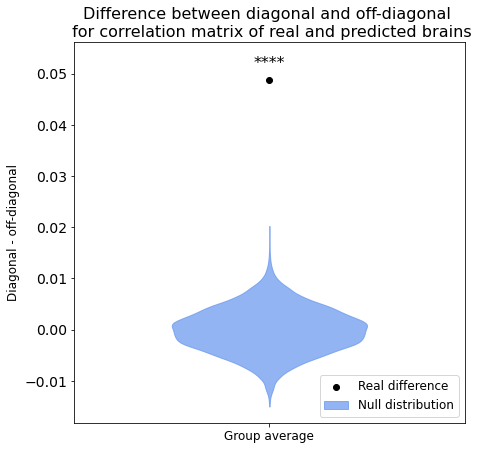

In [9]:
imgtofmri.twinset_random_group_permutations(n_shuffle=10000, print_vals=True)

In [3]:
imgtofmri.twinset_generate_category_correlations(output_dir)

Generating correlations for 'faces': 100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


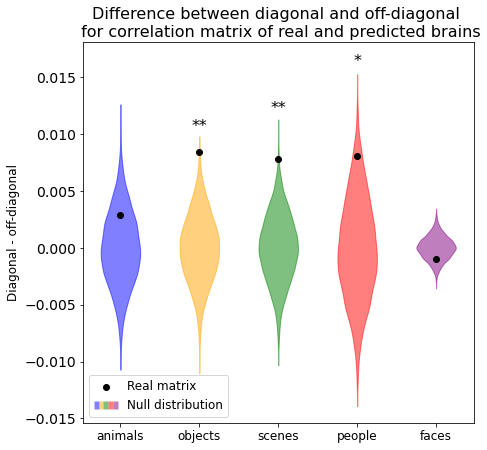

In [37]:
# imgtofmri.twinset_random_category_permutations(n_shuffle=1000, print_vals=True)
imgtofmri.twinset_random_category_permutations(n_shuffle=10000)

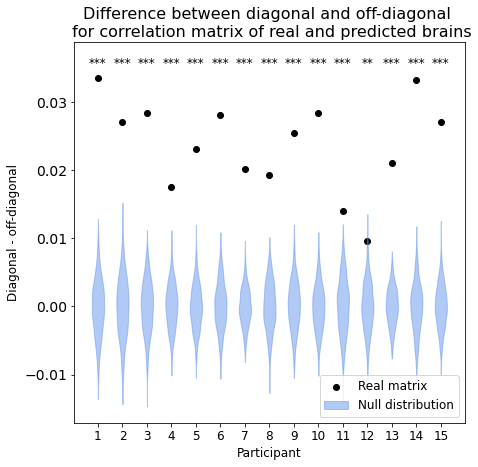

In [7]:
imgtofmri.twinset_random_participant_permutations(n_shuffle=1000)

### Generalizing image prediction to movies (Partly Cloudy)

In [77]:
from imgtofmri import *

In [78]:
true_dir = "../pc_true/preprocessed_data"
output_dir = "output/"
input_dir = "../partly_cloudy/"
overlap = get_subj_overlap()

In [79]:
# Loading predicted brains
pred = nib.load(f'{output_dir}/pred_avg_ra_dcto.nii.gz').get_fdata()
pred = pred[:,:,:,2:-8]
pred = np.corrcoef(pred[overlap].T)
# plt.imshow(pred)

In [80]:
# Loading Luminance model as comparison
lum = get_luminance(input_dir)
lum = np.corrcoef(lum)

Downsampling: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


In [81]:
# Loading True brains
true = nib.load(f'{true_dir}/avg_r_ro_m_s_z_ra_dcto.nii.gz').get_fdata()
true = true[:,:,:,10:]
true = np.corrcoef(true[overlap].T)
# plt.imshow(true)

Text(0.5, 0.98, 'Correlation matrices for Partly Cloudy')

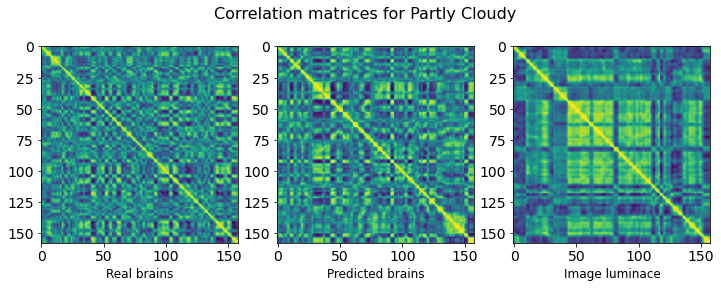

In [82]:
# Correlation matrices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].imshow(true)
axes[1].imshow(pred)
axes[2].imshow(lum)
axes[0].set_xlabel('Real brains', fontsize=12)
axes[1].set_xlabel('Predicted brains', fontsize=12)
axes[2].set_xlabel('Image luminace', fontsize=12)
fig.suptitle('Correlation matrices for Partly Cloudy', fontsize=16)

### Comparing performance between Predicted brains + Luminance model

In [83]:
corr = generate_bootstrapped_correlations(true, pred, lum, TR_band=None)

Generating and loading bootstraps: 100%|██████████| 100/100 [06:18<00:00,  3.79s/it]


#### On the full movie timecourse

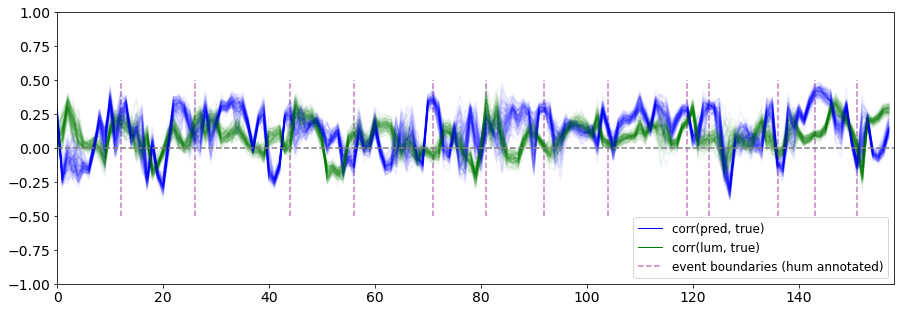

In [45]:
imgtofmri.pc_pred_lum_timecourse(corr)

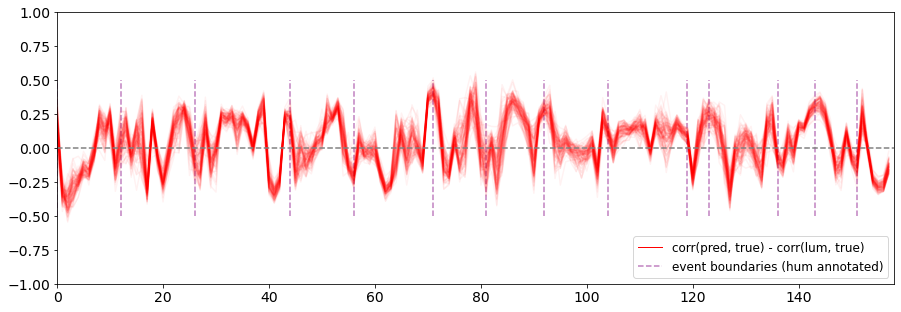

In [46]:
pc_difference_timecourse(corr)

#### Boundary triggered averages with bootstraps

In [84]:
bound_averages = generate_boundary_triggered_averages(corr)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:11<00:00, 87.09it/s]


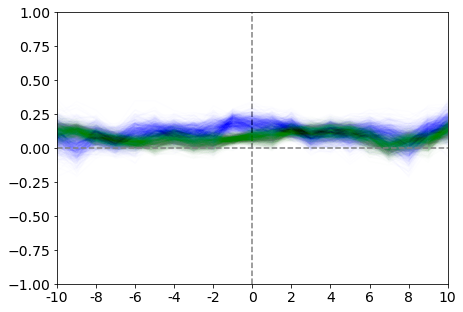

In [48]:
pc_bootstrapped_pred_lum(bound_averages)

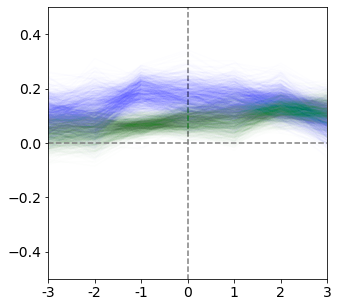

In [49]:
pc_bootstrapped_pred_lum_3TRs(bound_averages)

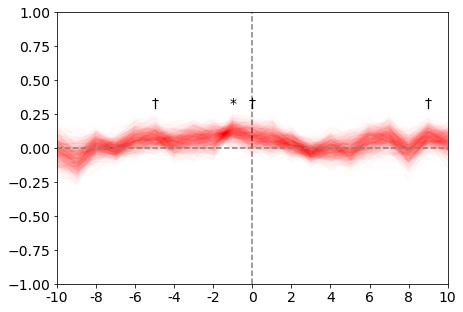

In [85]:
# without breaking y axis
pc_bootstrapped_difference(bound_averages)

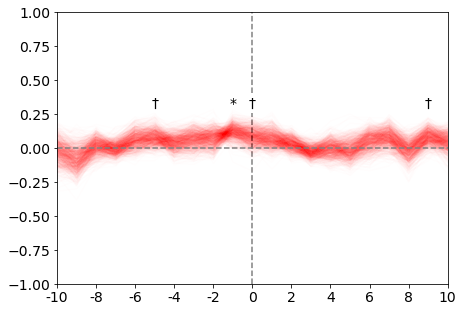

In [88]:
# with breaking y axis
pc_bootstrapped_difference(bound_averages)

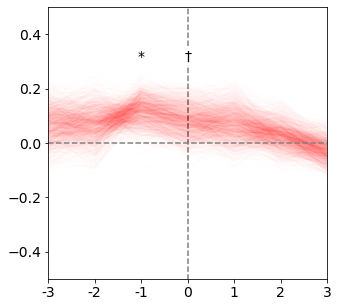

In [65]:
pc_bootstrapped_difference_3TRs(bound_averages)

## ±10 TRs

In [19]:
corr = generate_bootstrapped_correlations(true, pred, lum, TR_band=10)

Generating and loading bootstraps: 100%|██████████| 100/100 [07:15<00:00,  4.36s/it]


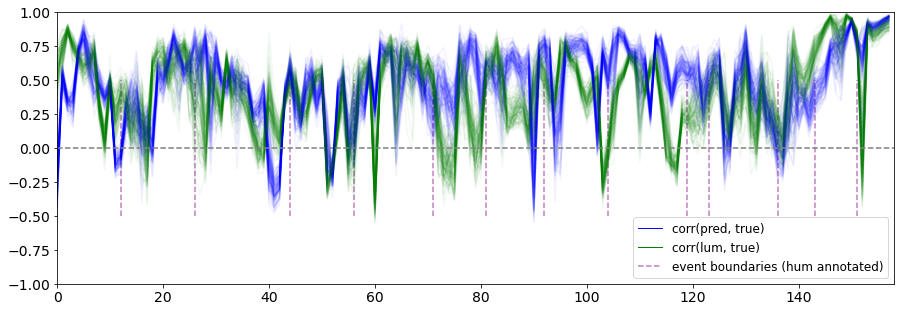

In [20]:
pc_pred_lum_timecourse(corr)

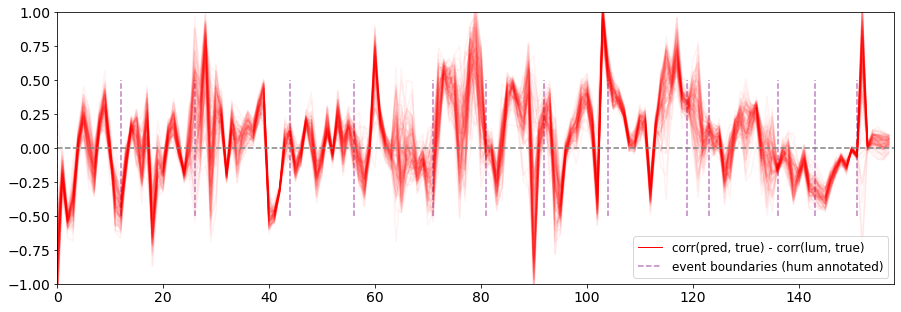

In [21]:
pc_difference_timecourse(corr)

## Boundary triggered averages

In [22]:
bound_averages = generate_boundary_triggered_averages(corr)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:14<00:00, 70.93it/s]


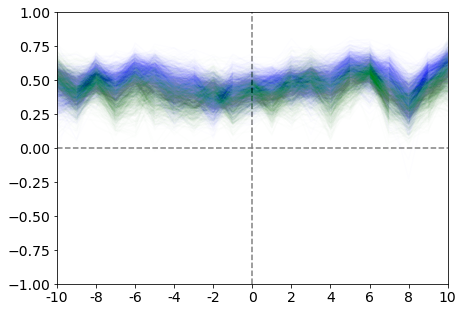

In [23]:
pc_bootstrapped_pred_lum(bound_averages)

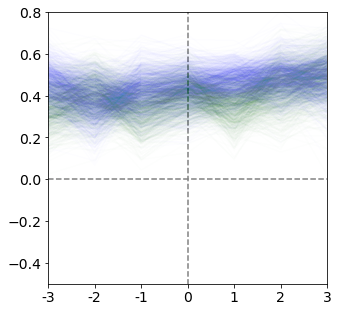

In [30]:
pc_bootstrapped_pred_lum_3TRs(bound_averages, y_max=0.8)

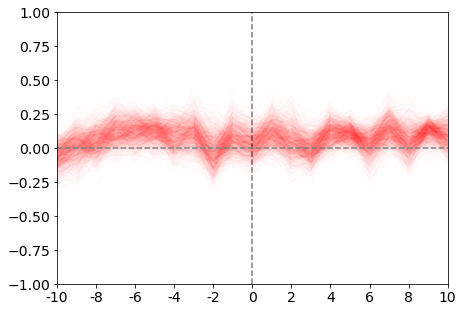

In [25]:
pc_bootstrapped_difference(bound_averages)

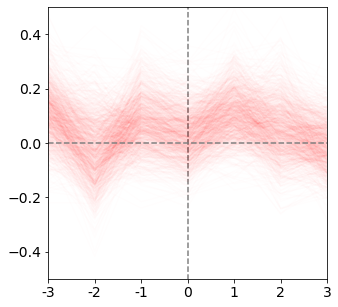

In [26]:
pc_bootstrapped_difference_3TRs(bound_averages)

### bandwidth testing

In [24]:
nTR = true.shape[0]
corr = np.zeros((2, nTR//2, nTR)) # pred,lum x band_width x corr(each_row) 
for b in range (1,nTR//2):
    upt = ~np.triu(np.ones(nTR).astype(bool), b + 1) # upper triangle of 0s
    lot = np.triu(np.ones(nTR).astype(bool), -b) # lower triangle of 0s
    band = upt & lot
    notdiag = 1-np.diag(np.ones(158)).astype(bool)
    band = band & notdiag
    band = band.astype(bool)

    for i in range(1, nTR-1):
        corr[0,b,i] = stats.pearsonr(pred[i][band[i]], true[i][band[i]])[0]
        corr[1,b,i] = stats.pearsonr(lum[i][band[i]], true[i][band[i]])[0]

mean_corr = np.zeros((2,nTR//2))
for b in range(1, nTR//2):
    mean_corr[0,b] = np.mean(corr[0,b,:])
    mean_corr[1,b] = np.mean(corr[1,b,:])

Text(0.5, 1.0, 'mean correlation of row x row corrs from TRxTR matrices')

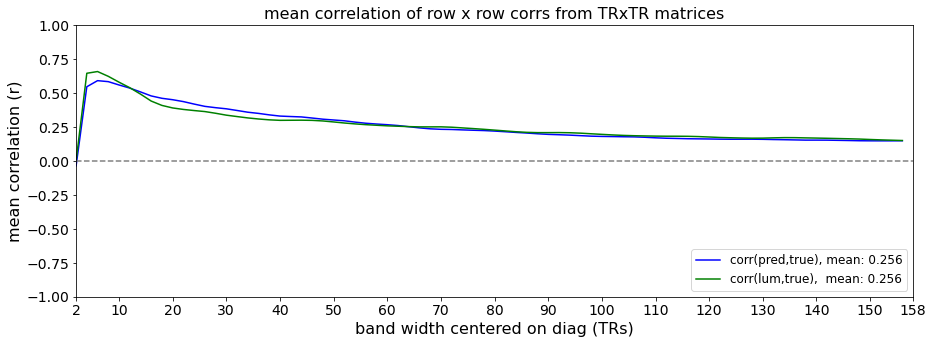

In [25]:
import matplotlib.ticker as ticker
plt.figure(figsize=(15, 5))
plt.tick_params(axis='x', top=False, labeltop=False)
plt.plot(mean_corr[0], color='blue', label=f'corr(pred,true), mean: {np.mean(corr[0]):.3f}')
plt.plot(mean_corr[1], color='green', label=f'corr(lum,true),  mean: {np.mean(corr[1]):.3f}')
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([1,nTR//2])
axes.set_ylabel("mean correlation (r)")
axes.set_xlabel("band width centered on diag (TRs)")

ticks = [i for i in np.concatenate(([2], np.arange(10,  nTR, step=10), [nTR]))/2]
ticklabels = [f'{i:.0f}' for i in np.concatenate(([2], np.arange(10,  nTR, step=10), [nTR]))]
axes.set_xticks(ticks)
axes.set_xticklabels(ticklabels)

plt.axhline(0, 0, nTR, linestyle='dashed', color='grey')
plt.legend(fontsize='large', loc='lower right')
plt.title("mean correlation of row x row corrs from TRxTR matrices")

#### Notes
- rewrite check for file suffix to be fn with list from beginning?

## Appendix

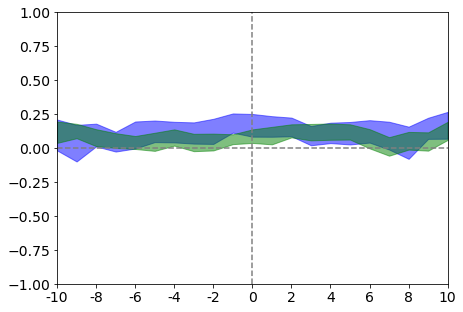

In [38]:
imgtofmri.pc_bootstrapped_pred_lum_conf_intervals(bound_averages)

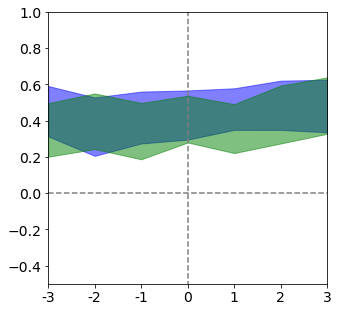

In [33]:
imgtofmri.pc_bootstrapped_pred_lum_3TRs_conf_intervals(bound_averages)

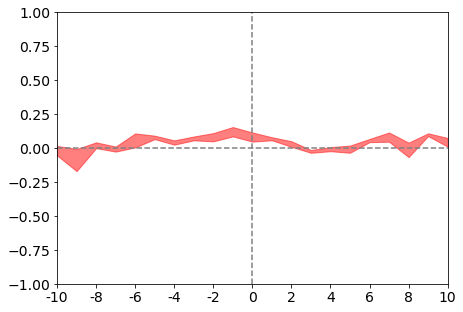

In [45]:
imgtofmri.pc_bootstrapped_difference_conf_intervals(bound_averages)

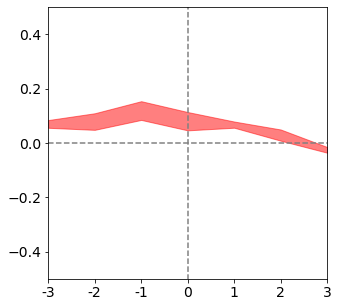

In [46]:
imgtofmri.pc_bootstrapped_difference_3TRs_conf_intervals(bound_averages)